# _**Feature Engineering for Fashion Retail Sales Analysis**_

## **Introduction**

This notebook focuses on feature engineering to prepare the cleaned dataset for predictive modeling and deeper insights into customer behavior. 
We will transform numerical features, extract time-based features, encode categorical variables, and create customer-level aggregates for further analysis.

**Objectives:**

- Extract useful time-based features (e.g., purchase month, day of week)
- Create customer-level flags (e.g., high spender)
- Encode categorical variables for modeling
- Prepare data for customer segmentation (e.g., Recency, Frequency, Monetary metrics)

## Import Libraries & Load Cleaned Dataset

In [43]:
# Import dependencies
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

In [44]:
# Load processed dataset
df = pd.read_csv("../data/processed/retail_cleaned_eda.csv")
# initial overview
print("Dataset Loaded Successfully!")
print("Shape of the dataset:", df.shape)
df.head()

Dataset Loaded Successfully!
Shape of the dataset: (3400, 7)


,customer_reference_id,item_purchased,purchase_amount_(usd),date_purchase,review_rating,payment_method,log_purchase_amount
0,4018,Handbag,4619.0,2023-02-05,3.2,Credit Card,8.438150
1,4115,Tunic,2456.0,2023-07-11,2.0,Credit Card,7.806696
2,4019,Tank Top,2102.0,2023-03-23,4.1,Cash,7.651120
3,4097,Leggings,3126.0,2023-03-15,3.2,Cash,8.047829
4,3997,Wallet,3003.0,2022-11-27,4.7,Cash,8.007700


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_reference_id  3400 non-null   int64  
 1   item_purchased         3400 non-null   object 
 2   purchase_amount_(usd)  3400 non-null   float64
 3   date_purchase          3400 non-null   object 
 4   review_rating          3400 non-null   float64
 5   payment_method         3400 non-null   object 
 6   log_purchase_amount    3400 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 186.1+ KB


## Feature Creation
### Transform Numerical Features - Log Transformation

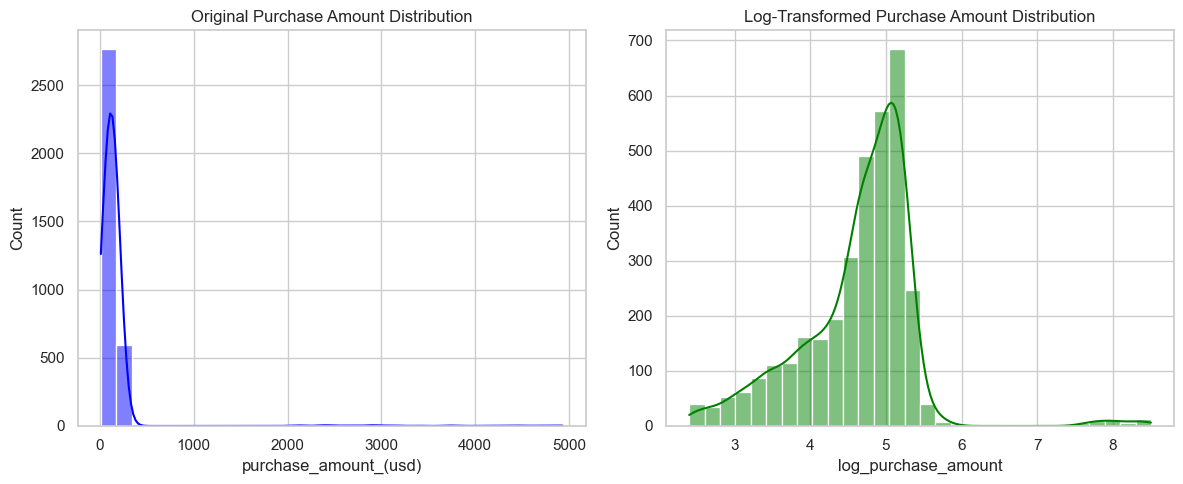

In [46]:
# Log-transform the purchase amount to reduce skewness
df['log_purchase_amount'] = np.log1p(df['purchase_amount_(usd)'])

# Visualize the distribution before and after transformation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['purchase_amount_(usd)'], kde=True, bins=30, color='blue')
plt.title("Original Purchase Amount Distribution")
plt.subplot(1, 2, 2)
sns.histplot(df['log_purchase_amount'], kde=True, bins=30, color='green')
plt.title("Log-Transformed Purchase Amount Distribution")
plt.tight_layout()
plt.show()

### Extract Time-Based Features

In [47]:
# Convert 'date_purchase' to datetime (if not already done)
df['date_purchase'] = pd.to_datetime(df['date_purchase'])

# Extract features from the purchase date
df['month'] = df['date_purchase'].dt.month
df['weekday'] = df['date_purchase'].dt.weekday
df['is_q4'] = df['date_purchase'].dt.quarter == 4

# Display a sample of extracted time-based features
df.sample(10)

,customer_reference_id,item_purchased,purchase_amount_(usd),date_purchase,review_rating,payment_method,log_purchase_amount,month,weekday,is_q4
1192,4003,Slippers,245.304348,2023-01-01,4.7,Cash,5.506568,1,6,False
483,3973,Gloves,189.000000,2022-10-30,2.5,Credit Card,5.247024,10,6,True
981,4108,Kimono,31.000000,2023-05-02,2.4,Cash,3.465736,5,1,False
1926,4118,Sneakers,173.000000,2023-09-14,2.0,Credit Card,5.159055,9,3,False
1913,4071,Pants,43.000000,2022-10-05,3.1,Credit Card,3.784190,10,2,True
791,4115,Raincoat,199.000000,2023-04-20,2.2,Credit Card,5.298317,4,3,False
1610,4038,Backpack,103.000000,2023-07-20,1.0,Cash,4.644391,7,3,False
991,4075,Socks,100.000000,2023-09-04,4.4,Credit Card,4.615121,9,0,False
1149,4034,Jumpsuit,114.217391,2023-01-29,3.5,Credit Card,4.746821,1,6,False
2548,4107,Flannel Shirt,102.377358,2023-04-09,2.6,Credit Card,4.638386,4,6,False


### Encode Categorical Variables: 

`Binary encode` *payment_method* and `label encode` *item_purchased*.

In [56]:
# Binary Encoding for 'payment_method'
df['payment_encoded'] = df['payment_method'].map({'Cash': 0, 'Credit Card': 1})

# Label encode 'item_purchased'
le = LabelEncoder()
df['item_encoded'] = le.fit_transform(df['item_purchased'])

# Save label mapping for reference
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
mapping_df = pd.DataFrame(list(label_mapping.items()), columns=['item_purchased', 'item_encoded'])
mapping_df.to_csv("../data/processed/item_encoding_mapping.csv", index=False)

### Identify High-Value Transactions

In [57]:
# Define high-value transaction threshold (90th percentile)
high_value_threshold = df['purchase_amount_(usd)'].quantile(0.9)
df['high_value_transaction'] = df['purchase_amount_(usd)'] > high_value_threshold

print("High-value transactions flagged.")
print(df[['purchase_amount_(usd)', 'high_value_transaction']].head())

High-value transactions flagged.
   purchase_amount_(usd)  high_value_transaction
0                 4619.0                    True
1                 2456.0                    True
2                 2102.0                    True
3                 3126.0                    True
4                 3003.0                    True


### Customer-Level Aggregations

In [58]:
# Average spend per customer
df_customer_spend = df.groupby('customer_reference_id')['purchase_amount_(usd)'].mean().reset_index()
df_customer_spend.rename(columns={'purchase_amount_(usd)': 'avg_spend'}, inplace=True)

# Frequency of purchases per customer
df_customer_frequency = df.groupby('customer_reference_id')['item_purchased'].count().reset_index()
df_customer_frequency.rename(columns={'item_purchased': 'purchase_frequency'}, inplace=True)

# Merge aggregates back to the main dataframe (optional)
df = df.merge(df_customer_spend, on='customer_reference_id', how='left')
df = df.merge(df_customer_frequency, on='customer_reference_id', how='left')

print("Aggregates added.")
df.head()

Aggregates added.


,customer_reference_id,item_purchased,purchase_amount_(usd),date_purchase,review_rating,payment_method,log_purchase_amount,month,weekday,is_q4,payment_encoded,item_encoded,high_value_transaction,avg_spend_x,purchase_frequency_x,avg_spend_y,purchase_frequency_y
0,4018,Handbag,4619.0,2023-02-05,3.2,Credit Card,8.438150,2,6,False,1,13,True,323.256828,20,323.256828,20
1,4115,Tunic,2456.0,2023-07-11,2.0,Credit Card,7.806696,7,1,False,1,46,True,215.240856,23,215.240856,23
2,4019,Tank Top,2102.0,2023-03-23,4.1,Cash,7.651120,3,3,False,0,42,True,245.146567,17,245.146567,17
3,4097,Leggings,3126.0,2023-03-15,3.2,Cash,8.047829,3,2,False,0,20,True,396.479758,11,396.479758,11
4,3997,Wallet,3003.0,2022-11-27,4.7,Cash,8.007700,11,6,True,0,49,True,255.734675,17,255.734675,17


### Customer Summary for Modeling

In [59]:
# Aggregate per customer (for segmentation or LTV modeling later)
customer_agg = df.groupby('customer_reference_id').agg(
    total_purchases=('purchase_amount_(usd)', 'sum'),
    avg_purchase_value=('purchase_amount_(usd)', 'mean'),
    num_transactions=('purchase_amount_(usd)', 'count'),
    last_purchase=('date_purchase', 'max'),
)

# Recency calculation (if needed later)
reference_date = df['date_purchase'].max()
customer_agg['recency_days'] = (reference_date - customer_agg['last_purchase']).dt.days

customer_agg.reset_index(inplace=True)

### Save Feature-Engineered Datasets

In [60]:
# Save full transactional data
df.to_parquet("../data/processed/retail_feature_engineered.parquet", index=False)

# Save customer aggregates separately
customer_agg.to_parquet("../data/processed/customer_features.parquet", index=False)
print("Feature engineering completed. Data saved to parquet files.")

Feature engineering completed. Data saved to parquet files.


## Next Steps

The feature-engineered dataset is now ready for modeling. In the next notebook (`03_modeling.ipynb`), we will:

- Train models to predict purchase amount at transaction level.
- Build customer-level models to identify high-value customers.
- Evaluate and compare models to choose the best performing ones.